# Anomaly Detection with PyOD
  - https://towardsdatascience.com/anomaly-detection-with-pyod-b523fc47db9
  - Date 31oct20      

C:\Users\Asus\Anaconda3\envs\ztdl\lib\site-packages\pyod\utils\data.py:190: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.8.0. Please use behaviour="new", which makes the returned datasets in the order of X_train, X_test, y_train, y_test.
  FutureWarning)


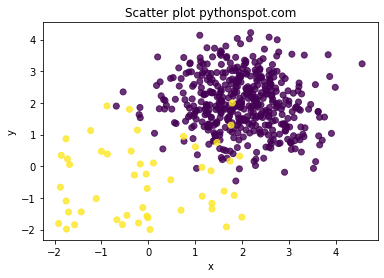

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyod.utils.data import generate_data
contamination = 0.1 # percentage of outliers
n_train = 500       # number of training points
n_test = 500        # number of testing points
n_features = 2      # number of features
X_train, y_train, X_test, y_test = generate_data(
 n_train=n_train, n_test=n_test, n_features= n_features, contamination=contamination)

# Make the 2d numpy array a pandas dataframe for each manipulation 
X_train_pd = pd.DataFrame(X_train)
    
# Plot
plt.scatter(X_train_pd[0], X_train_pd[1], c=y_train, alpha=0.8)
plt.title('Scatter plot pythonspot.com')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [2]:
# train kNN detector
from pyod.models.knn import KNN
clf_name = 'KNN'
clf = KNN()
clf.fit(X_train)
# If you want to see the predictions of the training data, you can use this way:
y_train_scores = clf.decision_scores_

In [3]:
# Now we have the trained K-NN model, let's apply to the test data to get the predictions
y_test_pred = clf.predict(X_test) # outlier labels (0 or 1)
# Because it is '0' and '1', we can run a count statistic. There are 44 '1's and 456 '0's. The number of anomalies is roughly ten percent, as we have generated before:
unique, counts = np.unique(y_test_pred, return_counts=True)
dict(zip(unique, counts))
#{0: 456, 1: 44}
# And you can generate the anomaly score using clf.decision_function:
y_test_scores = clf.decision_function(X_test)

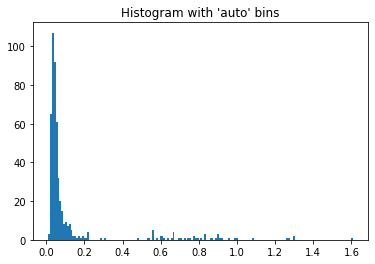

In [4]:
import matplotlib.pyplot as plt
plt.hist(y_test_scores, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins")
plt.show()

In [6]:

# Let's see how many '0's and '1's. We get 452 '0's and 48 '1's.
df_test = pd.DataFrame(X_test)
df_test['score'] = y_test_scores
df_test['cluster'] = np.where(df_test['score']<1, 0, 1)
df_test['cluster'].value_counts()
# Now let's show the summary statistics:
#df_test.groupby('y_by_average_cluster').mean()
df_test.groupby('cluster').mean()

,0,1,score
cluster,,,
0,1.804044,1.852546,0.114573
1,-1.032825,-1.241821,1.262319


In [7]:
from pyod.models.combination import aom, moa, average, maximization
from pyod.utils.utility import standardizer
# Standardize data
X_train_norm, X_test_norm = standardizer(X_train, X_test)
# Test a range of k-neighbors from 10 to 200. There will be 20 k-NN models.
n_clf = 20
k_list = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 
 120, 130, 140, 150, 160, 170, 180, 190, 200]
# Just prepare data frames so we can store the model results
train_scores = np.zeros([X_train.shape[0], n_clf])
test_scores = np.zeros([X_test.shape[0], n_clf])
train_scores.shape
# Modeling
for i in range(n_clf):
    k = k_list[i]
    clf = KNN(n_neighbors=k, method='largest')
    clf.fit(X_train_norm)

    # Store the results in each column:
    train_scores[:, i] = clf.decision_scores_
    test_scores[:, i] = clf.decision_function(X_test_norm) 
# Decision scores have to be normalized before combination
train_scores_norm, test_scores_norm = standardizer(train_scores,test_scores)

C:\Users\Asus\Anaconda3\envs\ztdl\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


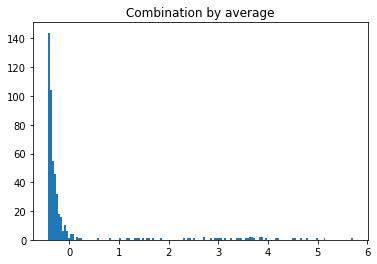

In [8]:
# Combination by average
# The test_scores_norm is 500 x 20. The "average" function will take the average of the 20 columns. The result "y_by_average" is a single column: 
y_by_average = average(test_scores_norm)
import matplotlib.pyplot as plt
plt.hist(y_by_average, bins='auto') # arguments are passed to np.histogram
plt.title("Combination by average")
plt.show()

In [9]:
df_test = pd.DataFrame(X_test)
df_test['y_by_average_score'] = y_by_average
df_test['y_by_average_cluster'] = np.where(df_test['y_by_average_score']<0, 0, 1)
df_test['y_by_average_cluster'].value_counts()

0    438
1     62
Name: y_by_average_cluster, dtype: int64

In [11]:
df_test.groupby('y_by_average_cluster').mean()

,0,1,y_by_average_score
y_by_average_cluster,,,
0,1.991054,1.997874,-0.324569
1,0.162623,0.476508,2.459368


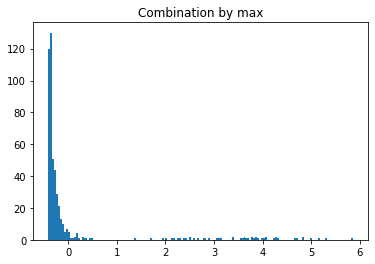

In [12]:
# Combination by mom
y_by_maximization = maximization(test_scores_norm)
             
import matplotlib.pyplot as plt
plt.hist(y_by_maximization, bins='auto')  # arguments are passed to np.histogram
plt.title("Combination by max")
plt.show()

In [13]:
df_test = pd.DataFrame(X_test)
df_test['y_by_maximization_score'] = y_by_maximization
df_test['y_by_maximization_cluster'] = np.where(df_test['y_by_maximization_score']<0, 0, 1)
df_test['y_by_maximization_cluster'].value_counts()

0    431
1     69
Name: y_by_maximization_cluster, dtype: int64

In [14]:
df_test.groupby('y_by_maximization_cluster').mean()

,0,1,y_by_maximization_score
y_by_maximization_cluster,,,
0,1.995310,1.999030,-0.307122
1,0.321526,0.623634,2.577009


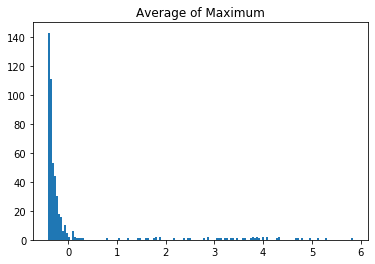

In [16]:

# Combination by aom
y_by_aom = aom(test_scores_norm, n_buckets=5)
             
import matplotlib.pyplot as plt
plt.hist(y_by_aom, bins='auto')  # arguments are passed to np.histogram
plt.title("Average of Maximum")
plt.show()

In [18]:
df_test = pd.DataFrame(X_test)
df_test['y_by_aom_score'] = y_by_aom
df_test['y_by_aom_cluster'] = np.where(df_test['y_by_aom_score']<0, 0, 1)
df_test['y_by_aom_cluster'].value_counts()
df_test.groupby('y_by_aom_cluster').mean()

,0,1,y_by_aom_score
y_by_aom_cluster,,,
0,1.992001,1.997104,-0.311443
1,0.213304,0.529298,2.540803


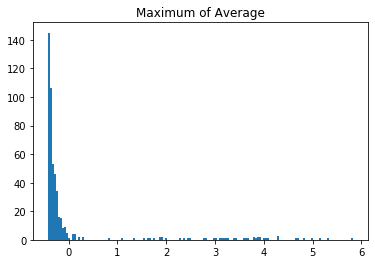

In [19]:
# Combination by moa
y_by_moa = moa(test_scores_norm, n_buckets=5)

import matplotlib.pyplot as plt
plt.hist(y_by_moa, bins='auto')  # arguments are passed to np.histogram
plt.title("Maximum of Average")
plt.show()

In [20]:
df_test = pd.DataFrame(X_test)
df_test['y_by_moa_score'] = y_by_moa
df_test['y_by_moa_cluster'] = np.where(df_test['y_by_moa_score']<0, 0, 1)
df_test['y_by_moa_cluster'].value_counts()
df_test.groupby('y_by_moa_cluster').mean()

,0,1,y_by_moa_score
y_by_moa_cluster,,,
0,1.990743,1.996604,-0.315590
1,0.193800,0.509468,2.593376


In [21]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
samples = X_train[0:5]
samples

array([[2.1737301 , 2.17997793],
       [2.27087052, 2.09820447],
       [2.14585678, 2.21410405],
       [1.9139248 , 1.89963824],
       [2.01398543, 1.80980687]])

In [22]:

my_knn = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(samples)
distances, indices = my_knn.kneighbors(samples, return_distance=True)
distances

array([[0.        , 0.04406261],
       [0.        , 0.126977  ],
       [0.        , 0.04406261],
       [0.        , 0.1344686 ],
       [0.        , 0.1344686 ]])

In [23]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0).fit(samples)
kmeans.labels_

array([1, 1, 1, 0, 0])

In [24]:
centroids = kmeans.cluster_centers_
centroids

array([[1.96395511, 1.85472255],
       [2.19681913, 2.16409548]])